#**Unit Disk graphs**
DEN model to solve constrained unit disk graph problem.
* clone repository (codes building blocks and graphs dataset)
* install needed libraries
* Improve the embedding solutions by increasing the adjacency gap

In [1]:
!git clone https://github.com/LINKS-Foundation-CPE/Master-QCC-2022-2023.git

Cloning into 'Master-QCC-2022-2023'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 145 (delta 65), reused 116 (delta 44), pack-reused 0
Receiving objects: 100% (145/145), 421.08 KiB | 9.57 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [1]:
!pip install pulser==0.17.4
!pip install networkx==2.8.7

In [3]:
%cd /content/Master-QCC-2022-2023/

/content/Master-QCC-2022-2023


In [2]:
%matplotlib inline

In [7]:
import numpy as np
import torch
import networkx as nx
from pulser.devices import AnalogDevice
from src.embedding.ud_graphs import *
from src.embedding.Coords import Coords
from src.embedding.train_utils import *

In [8]:
class DEN(torch.nn.Module):
    """ DEN model: Autoencoder network with additional sparse layers that allows the computation of squared Euclidean
        distaces between pairs of points as output of the forward step.
    """

    def __init__(self, num_vertexes, p_drop=0.5, max_value=50, dim=2):
        super(DEN, self).__init__()
        """ Initialize DEN model attributes.

        Args:
            num_vertexes ( int ): number of vertexes, i.e. points
            p_drop (float, optional): dropout probability. Defaults to 0.5.
            max_value (float, optional): maximum value that determines coordinates range. Defaults to 50.
            dim (int, optional): dimensionality of the points. Defaults to 2.
        """ 
        
        # initialize attributes    
        self.num_vertexes = num_vertexes
        self.num_edges = num_vertexes*(num_vertexes-1)//2
        self.max_value = max_value
        self.dim = dim
        self.pairs_dict = compute_pairs_dict(range(num_vertexes))
        # define encoder architecture
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.num_vertexes*self.dim, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p_drop),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Dropout(p_drop),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Dropout(p_drop),
            torch.nn.Linear(18, 9)
        )
        # define decoder architecture
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Dropout(p_drop),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p_drop),
            torch.nn.Linear(64, self.dim*num_vertexes)
        )   
        # define the coordinates layer    
        self.coords_layer = Coords(self.max_value)
        # define difference layer
        self.diff_layer = self.difference_pairs()
        # define the sum layer
        self.sum_layer = self.sum_pairs()            
        
        
    def forward(self, x):
        """Define the forward step.

        Args:
            x ( torch.Tensor ): input tensor.

        Returns:
             torch.Tensor : output tensor.
        """
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.coords_layer(x)
        # save the current coordinates
        self.pos = x.detach().clone().numpy().reshape(self.num_vertexes, self.dim, order='F')
        x = self.diff_layer(x)     
        x = torch.square(x)
        x = self.sum_layer(x)  
        # save the current pair distancces
        self.dist = x.detach().clone().numpy()  
        return x


    def difference_pairs(self):
        """Define the difference layer.

        Returns:
             torch.nn.Linear : fully connected layer with non-trainable weights that implements difference between pairs of coordinates.
        """
        difference = torch.nn.Linear(self.dim*self.num_vertexes, self.dim*self.num_edges, bias=False)
        difference.weight.requires_grad=False
        torch.nn.init.constant_(difference.weight,0)        
        for line in range(self.num_edges):                   
            elem1 = self.pairs_dict[line][0]
            elem2 = self.pairs_dict[line][1]
            # difference between x
            difference.weight[line, elem1]=1
            difference.weight[line, elem2]=-1
            # difference between y
            difference.weight[line+self.num_edges, elem1+self.num_vertexes]=1
            difference.weight[line+self.num_edges, elem2+self.num_vertexes]=-1
            if self.dim==3:
                # difference between z
                difference.weight[line+2*self.num_edges, elem1+2*self.num_vertexes]=1
                difference.weight[line+2*self.num_edges, elem2+2*self.num_vertexes]=-1               
        return difference  
              
            
    def sum_pairs(self):
        """Define the sum layer.

        Returns:
             torch.nn.Linear : fully connected layer with non-trainable weights that implements squared distances computation.
        """
        sum_square = torch.nn.Linear(self.dim*self.num_edges, self.num_edges, bias=False)
        sum_square.weight.requires_grad=False
        torch.nn.init.constant_(sum_square.weight,0)
        for line in range(self.num_edges):
            # sum x contribution
            sum_square.weight[line, line]=1
            # sum y contribution
            sum_square.weight[line, line+self.num_edges]=1
            if self.dim==3:
                # sum z contribution
                sum_square.weight[line, line+2*self.num_edges]=1
        return sum_square


In [6]:
def embedding_loss(output_dists, adj_tensor, device, gap=0.1, square_domain=False, max_dist_feasible=100, max_adj_feasible=10, min_dist_feasible=4):
    """Compute the embedding loss.

    Args:
        output_dists ( torch.Tensor ): output of the Distance Encoder Network model.
        adj_tensor ( torch.Tensor ): tensor that specifies if the pair, associated with the pair distance, shares and edge.
        device ( torch.device ): specify the device for the Network training.
        gap (float, optional): adjacency gap that is targeted. Defaults to 0.1.
        square_domain (bool, optional): flag that specify if the embedding domain is squared. Defaults to False.
        max_dist_feasible (float, optional): maximum allowed distance among vertexes. Defaults to 100.
        max_adj_feasible (float, optional): maximum allowed distance among adjacent vertexes. Defaults to 10.
        min_dist_feasible (float, optional):  minimum allowed distance among vertexes. Defaults to 4.

    Returns:
         torch.FloatTensor : loss function contribution associated with minimum distance constraint violation.
         torch.FloatTensor : loss function contribution associated with maximum distance constraint violation.
    """
    num_pairs = output_dists.shape[0]
    # define a tensor that contains the minimum allowed squared distances for all pairs
    min_dist_tensor = torch.ones(num_pairs)*(min_dist_feasible)**2
    min_dist_tensor[adj_tensor==0]=(max_adj_feasible+gap)**2
    # define a tensor that contains the maximum allowed squared distances for all pairs
    if square_domain:
        max_dist_tensor = torch.ones(num_pairs)*(max_dist_feasible*np.sqrt(2))**2    
    else:        
        max_dist_tensor = torch.ones(num_pairs)*(max_dist_feasible)**2       
    max_dist_tensor[adj_tensor==1]=(max_adj_feasible)**2  
    # compute losses' values
    target_min = torch.ones(num_pairs)
    loss_min = torch.nn.MarginRankingLoss()(output_dists,min_dist_tensor.to(device),target_min)    
    target_max = -torch.ones(num_pairs)          
    loss_max = torch.nn.MarginRankingLoss()(output_dists,max_dist_tensor.to(device),target_max)   
     
    return loss_min, loss_max


Initial embedding:
	 d : 26.162242454649125
	 D : 138.29686782274894
	 D_adj : 82.02509489493558
	 d_not_adj : 71.0620983705963
First feasible embedding at epoch 770
First feasible energy gap 2.3469009181430054
Final embedding:
	 d : 4.237906410923866
	 D : 19.050689897346714
	 D_adj : 10.174607195125992
	 d_not_adj : 12.284214642306155
Best feasible energy gap 3.097265732186375


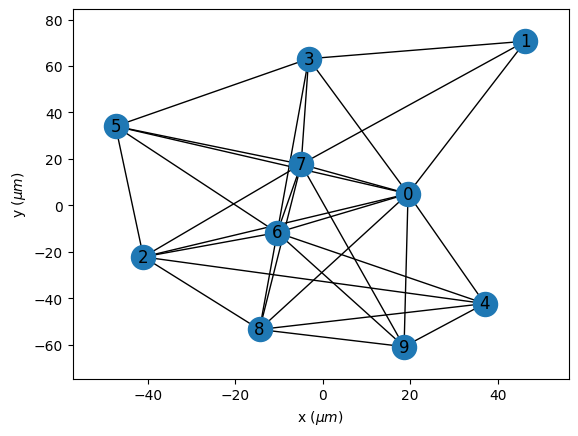

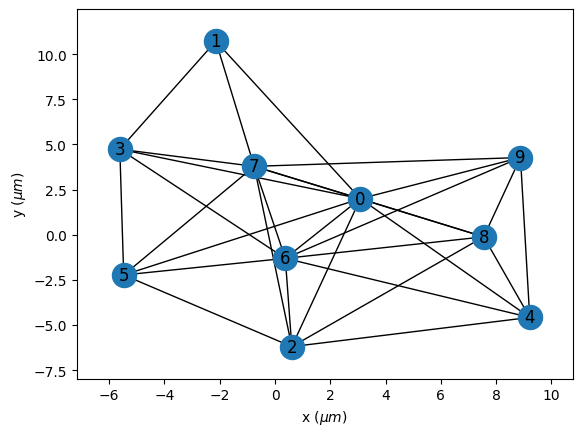

In [10]:
set_seed(7)
max_dist=100
min_dist=4
dim = 2
set_init_pos='FR'
# machine decoherence time
max_mus_machine=3
min_freq = np.pi/(np.sqrt(2)*max_mus_machine)
# blockade radius
max_dist_adj = AnalogDevice.rydberg_blockade_radius(min_freq)
num_vertexes=10
file_path="graphs/{}G_{}ud.gpickle".format(num_vertexes, 1)

# preprocessing phase
G_init, init_pos = load_graph(file_path, max_dist, set_init_pos, dim)  
A, not_A= compute_adj_mtx(G_init)
D_init = distance_matrix(init_pos, init_pos)
d_init, D_init, D_adj_init, d_not_adj_init = compute_dists_minmax(D_init, A, not_A)
print(f'Initial embedding:\n\t d : {d_init}\n\t D : {D_init}\n\t D_adj : {D_adj_init}\n\t d_not_adj : {d_not_adj_init}')
device = torch.device('cpu')
adj_tensor = compute_adj_tensor(A)

# initial coordinates tensor
init_pos_tensor = torch.Tensor(init_pos.T.flatten()).to(device)

# initialize the DEN model
DEN_model =  DEN(num_vertexes, dim=dim).to(device)
optimizer = torch.optim.AdamW(DEN_model.parameters(), lr=1e-3)     

best_gap = -1
gap_loss = 0.1
epoch=0

# learning phase    
while epoch <= 1000:            
    with torch.autograd.set_detect_anomaly(True): 

        # train step
        DEN_model.train()
        output_dists_train = DEN_model(init_pos_tensor)      
        optimizer.zero_grad()
        loss_min, loss_max = embedding_loss(output_dists_train, adj_tensor, device, gap=gap_loss, max_adj_feasible=max_dist_adj)        
        loss_val = loss_min + loss_max            
        loss_val.backward()
        optimizer.step()
        
        
        # inference step
        DEN_model.eval()
        _ = DEN_model(init_pos_tensor) 
        den_pos = DEN_model.pos
        D = distance_matrix(den_pos, den_pos)
        found_feasible, gap = check_feasible_embedding(D, A, not_A, min_dist, max_dist, max_dist_adj)
        if found_feasible and gap > best_gap:
            if best_gap==-1:
                print(f'First feasible embedding at epoch {epoch}')
                _, _, D_adj, d_not_adj = compute_dists_minmax(D, A, not_A)
                print(f'First feasible energy gap {(d_not_adj/D_adj)**6}')
            # optimize the adjacency gap
            gap_loss*=2 
            D_den = D    
            best_gap = gap  
            best_pos = den_pos     
    epoch+=1

if best_gap > 0:
    # retrive the best feasible solution found so far
    d, D, D_adj, d_not_adj = compute_dists_minmax(D_den, A, not_A)
    print(f'Final embedding:\n\t d : {d}\n\t D : {D}\n\t D_adj : {D_adj}\n\t d_not_adj : {d_not_adj}')

    print(f'Best feasible energy gap {(d_not_adj/D_adj)**6}')
    ud_G = nx.Graph()
    
    init_pos_dict, feasible_pos_dict = positions_dict(G_init, init_pos, best_pos)
    max_dist_n1 = D_den.argmax()//num_vertexes
    max_dist_n2 = D_den.argmax()%num_vertexes
    center = (best_pos[max_dist_n1]+best_pos[max_dist_n2])/2

    for n, coords in feasible_pos_dict.items():
        ud_G.add_node(n,pos=tuple(coords-center))  
    ud_G.add_edges_from(G_init.edges())
    
    # show results
    if dim==2:
        visualize_2d(ud_G, init_pos_dict)
        visualize_2d(ud_G, feasible_pos_dict)
    else:
        visualize_3d(ud_G, init_pos_dict)
        visualize_3d(ud_G, feasible_pos_dict)


